In [1]:
import json

with open("/home/huy/Project/educAItion/data.json", "r", encoding="utf-8") as file:
    data = json.load(file)

question_count = sum(len(topic["questions"]) for chapter in data["data"] for topic in chapter["topics"])

print("Total number of questions:", question_count)


Total number of questions: 162


In [2]:


PROMPT_text = """
Hãy giải bài toán theo từng bước, và giải thích bước làm.
Hãy trả về kết quả dạng LaTeX cho các công thức toán học (để trong $...$ cho các biểu thức, số), bảng biến thiên, đồ thị,... nếu có.

=========
Đây là bài toán:
{problem}

=========

LƯU Ý: 
- Hãy giải bằng cách ngắn gọn, hiệu quả nhất.
- Hãy trình bày khoa học và dùng các ký hiệu toán học nếu có thể để thay cho chữ 
- Ví dụ dùng kí hiệu toán là dấu "hoặc", "và" khi giải phương trình, bất phương trình; Hay vẽ bảng biến thiên khảo sát hàm số hay xét dấu,.... 
- Nên xuống dòng khi cần thiết, tránh một dòng quá dài.
-Trả về dưới dạng tag : <solution>solution<solution> <answer>answer<answer> trong đó solution là cách giải, anser là kết quả cuối cùng theo yêu cầu bài toán.
-Trả về kết quả dưới dạng Latex
"""

In [1]:

from dotenv import load_dotenv
import os
from google import genai

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
gemini_api_key = os.getenv("GEMINI_API_KEY")

from langchain_openai import OpenAI, ChatOpenAI
from typing import List, Dict, Any, Optional, Tuple
from abc import ABC, abstractmethod
from langchain.schema.messages import HumanMessage, SystemMessage


class LLM(ABC):
    @abstractmethod
    def generate(self, prompt: str) -> str:
        pass
    
    @abstractmethod
    def stream_generate(self, prompt: str):
        pass

class LangchainOpenAI(LLM):
    def __init__(self, model_name="gpt-4o-mini"):
        self.chat_model = ChatOpenAI(
            model=model_name,
            temperature=0
        )
        self.stream_model = ChatOpenAI(
            model=model_name,
            temperature=0,
            streaming=True
        )
    
    def generate(self, prompt: str) -> str:
        messages = [HumanMessage(content=prompt)]
        return self.chat_model.invoke(messages).content
    
    def stream_generate(self, prompt: str):
        messages = [HumanMessage(content=prompt)]
        for chunk in self.stream_model.stream(messages):
            if chunk.content:
                yield chunk.content

class GeminiAI(LLM):
    def __init__(self):
        self.client = genai.Client(api_key=gemini_api_key)
    
    def generate(self, prompt: str) -> str:
        response = self.client.models.generate_content(model="gemini-2.0-flash",contents=[prompt])
        return response.text
    

    def stream_generate(self, prompt: str):
        response = self.client.models.generate_content_stream(model="gemini-2.0-flash",contents=[prompt])
        
        for chunk in response:
            if chunk.text:
                yield chunk.text

In [2]:

import re
import pandas as pd

from IPython.display import display, Latex
import json

from tqdm import tqdm

model = LangchainOpenAI()
def get_answer(problem):
    response =  model.generate(PROMPT_text.format(problem=problem))
    if response is None:
            return {"solution": "AI failed to generate a solution", "answer": "AI failed to generate an answer"}
    solution_match = re.search(r"<solution>(.*?)</solution>", response, re.DOTALL)
    answer_match = re.search(r"<answer>(.*?)</answer>", response, re.DOTALL)
    
    # Extracted values or default
    solution = solution_match.group(1) if solution_match else "No solution found"
    answer = answer_match.group(1) if answer_match else "No answer found"
    
    return {"solution": solution, "answer": answer}

In [5]:
rows = []
questions_list = [q for chapter in data["data"] for topic in chapter["topics"] for q in topic["questions"]]

for q in tqdm(questions_list, desc="Processing Questions"):
    ai_response = get_answer(q["question"])
    display(Latex(ai_response["solution"]))
    rows.append([
        q["question"], 
        q["solution"], 
        q["answer"], 
        ai_response["solution"], 
        ai_response["answer"]
    ])

# Create DataFrame
df = pd.DataFrame(rows, columns=["Question", "Solution", "Answer", "AI Solution", "AI Answer"])


# Display DataFrame
display(df)

<IPython.core.display.Latex object>

Processing Questions:  17%|█▋        | 28/162 [03:25<19:19,  8.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  18%|█▊        | 29/162 [03:31<17:16,  7.79s/it]

<IPython.core.display.Latex object>

Processing Questions:  19%|█▊        | 30/162 [03:45<21:20,  9.70s/it]

<IPython.core.display.Latex object>

Processing Questions:  19%|█▉        | 31/162 [03:57<22:31, 10.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  20%|█▉        | 32/162 [04:09<23:41, 10.94s/it]

<IPython.core.display.Latex object>

Processing Questions:  20%|██        | 33/162 [04:16<21:07,  9.82s/it]

<IPython.core.display.Latex object>

Processing Questions:  21%|██        | 34/162 [04:38<28:22, 13.30s/it]

<IPython.core.display.Latex object>

Processing Questions:  22%|██▏       | 35/162 [04:53<29:34, 13.98s/it]

<IPython.core.display.Latex object>

Processing Questions:  22%|██▏       | 36/162 [05:04<27:06, 12.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  23%|██▎       | 37/162 [05:06<20:23,  9.79s/it]

<IPython.core.display.Latex object>

Processing Questions:  23%|██▎       | 38/162 [05:12<17:26,  8.44s/it]

<IPython.core.display.Latex object>

Processing Questions:  24%|██▍       | 39/162 [05:19<16:31,  8.06s/it]

<IPython.core.display.Latex object>

Processing Questions:  25%|██▍       | 40/162 [05:24<14:25,  7.09s/it]

<IPython.core.display.Latex object>

Processing Questions:  25%|██▌       | 41/162 [05:28<12:32,  6.22s/it]

<IPython.core.display.Latex object>

Processing Questions:  26%|██▌       | 42/162 [05:37<14:10,  7.09s/it]

<IPython.core.display.Latex object>

Processing Questions:  27%|██▋       | 43/162 [05:43<13:32,  6.83s/it]

<IPython.core.display.Latex object>

Processing Questions:  27%|██▋       | 44/162 [05:55<16:32,  8.41s/it]

<IPython.core.display.Latex object>

Processing Questions:  28%|██▊       | 45/162 [06:10<20:02, 10.27s/it]

<IPython.core.display.Latex object>

Processing Questions:  28%|██▊       | 46/162 [06:23<21:13, 10.98s/it]

<IPython.core.display.Latex object>

Processing Questions:  29%|██▉       | 47/162 [06:47<28:48, 15.03s/it]

<IPython.core.display.Latex object>

Processing Questions:  30%|██▉       | 48/162 [06:56<25:17, 13.31s/it]

<IPython.core.display.Latex object>

Processing Questions:  30%|███       | 49/162 [07:12<26:14, 13.93s/it]

<IPython.core.display.Latex object>

Processing Questions:  31%|███       | 50/162 [07:22<23:42, 12.70s/it]

<IPython.core.display.Latex object>

Processing Questions:  31%|███▏      | 51/162 [07:35<24:01, 12.99s/it]

<IPython.core.display.Latex object>

Processing Questions:  32%|███▏      | 52/162 [07:47<23:17, 12.70s/it]

<IPython.core.display.Latex object>

Processing Questions:  33%|███▎      | 53/162 [07:59<22:44, 12.52s/it]

<IPython.core.display.Latex object>

Processing Questions:  33%|███▎      | 54/162 [08:15<24:07, 13.40s/it]

<IPython.core.display.Latex object>

Processing Questions:  34%|███▍      | 55/162 [08:26<22:59, 12.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  35%|███▍      | 56/162 [08:34<20:03, 11.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  35%|███▌      | 57/162 [08:48<21:00, 12.00s/it]

<IPython.core.display.Latex object>

Processing Questions:  36%|███▌      | 58/162 [08:55<18:17, 10.56s/it]

<IPython.core.display.Latex object>

Processing Questions:  36%|███▋      | 59/162 [09:05<18:06, 10.55s/it]

<IPython.core.display.Latex object>

Processing Questions:  37%|███▋      | 60/162 [09:12<15:48,  9.30s/it]

<IPython.core.display.Latex object>

Processing Questions:  38%|███▊      | 61/162 [09:21<15:31,  9.22s/it]

<IPython.core.display.Latex object>

Processing Questions:  38%|███▊      | 62/162 [09:30<15:11,  9.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  39%|███▉      | 63/162 [09:38<14:40,  8.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  40%|███▉      | 64/162 [09:53<17:32, 10.74s/it]

<IPython.core.display.Latex object>

Processing Questions:  40%|████      | 65/162 [10:03<16:44, 10.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  41%|████      | 66/162 [10:11<15:39,  9.79s/it]

<IPython.core.display.Latex object>

Processing Questions:  41%|████▏     | 67/162 [10:23<16:34, 10.46s/it]

<IPython.core.display.Latex object>

Processing Questions:  42%|████▏     | 68/162 [10:30<14:50,  9.47s/it]

<IPython.core.display.Latex object>

Processing Questions:  43%|████▎     | 69/162 [10:38<13:49,  8.92s/it]

<IPython.core.display.Latex object>

Processing Questions:  43%|████▎     | 70/162 [10:45<12:54,  8.41s/it]

<IPython.core.display.Latex object>

Processing Questions:  44%|████▍     | 71/162 [10:54<13:06,  8.64s/it]

<IPython.core.display.Latex object>

Processing Questions:  44%|████▍     | 72/162 [11:03<12:47,  8.53s/it]

<IPython.core.display.Latex object>

Processing Questions:  45%|████▌     | 73/162 [11:10<12:13,  8.24s/it]

<IPython.core.display.Latex object>

Processing Questions:  46%|████▌     | 74/162 [11:18<12:01,  8.20s/it]

<IPython.core.display.Latex object>

Processing Questions:  46%|████▋     | 75/162 [11:27<11:55,  8.23s/it]

<IPython.core.display.Latex object>

Processing Questions:  47%|████▋     | 76/162 [11:45<16:08, 11.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  48%|████▊     | 77/162 [11:55<15:27, 10.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  48%|████▊     | 78/162 [12:06<15:27, 11.04s/it]

<IPython.core.display.Latex object>

Processing Questions:  49%|████▉     | 79/162 [12:17<15:10, 10.97s/it]

<IPython.core.display.Latex object>

Processing Questions:  49%|████▉     | 80/162 [12:21<12:02,  8.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  50%|█████     | 81/162 [12:28<11:22,  8.43s/it]

<IPython.core.display.Latex object>

Processing Questions:  51%|█████     | 82/162 [12:38<11:32,  8.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  51%|█████     | 83/162 [12:42<09:33,  7.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  52%|█████▏    | 84/162 [12:47<08:47,  6.77s/it]

<IPython.core.display.Latex object>

Processing Questions:  52%|█████▏    | 85/162 [12:56<09:24,  7.34s/it]

<IPython.core.display.Latex object>

Processing Questions:  53%|█████▎    | 86/162 [13:06<10:26,  8.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  54%|█████▎    | 87/162 [13:17<11:03,  8.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  54%|█████▍    | 88/162 [13:27<11:27,  9.29s/it]

<IPython.core.display.Latex object>

Processing Questions:  55%|█████▍    | 89/162 [13:35<10:49,  8.90s/it]

<IPython.core.display.Latex object>

Processing Questions:  56%|█████▌    | 90/162 [13:40<09:28,  7.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  56%|█████▌    | 91/162 [13:45<08:03,  6.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  57%|█████▋    | 92/162 [13:53<08:23,  7.20s/it]

<IPython.core.display.Latex object>

Processing Questions:  57%|█████▋    | 93/162 [14:01<08:39,  7.53s/it]

<IPython.core.display.Latex object>

Processing Questions:  58%|█████▊    | 94/162 [14:07<07:56,  7.01s/it]

<IPython.core.display.Latex object>

Processing Questions:  59%|█████▊    | 95/162 [14:20<09:50,  8.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  59%|█████▉    | 96/162 [14:35<11:37, 10.56s/it]

<IPython.core.display.Latex object>

Processing Questions:  60%|█████▉    | 97/162 [14:48<12:14, 11.30s/it]

<IPython.core.display.Latex object>

Processing Questions:  60%|██████    | 98/162 [14:53<10:18,  9.67s/it]

<IPython.core.display.Latex object>

Processing Questions:  61%|██████    | 99/162 [15:02<09:50,  9.37s/it]

<IPython.core.display.Latex object>

Processing Questions:  62%|██████▏   | 100/162 [15:14<10:27, 10.13s/it]

<IPython.core.display.Latex object>

Processing Questions:  62%|██████▏   | 101/162 [15:22<09:39,  9.50s/it]

<IPython.core.display.Latex object>

Processing Questions:  63%|██████▎   | 102/162 [15:29<08:50,  8.84s/it]

<IPython.core.display.Latex object>

Processing Questions:  64%|██████▎   | 103/162 [15:38<08:46,  8.93s/it]

<IPython.core.display.Latex object>

Processing Questions:  64%|██████▍   | 104/162 [15:49<09:07,  9.44s/it]

<IPython.core.display.Latex object>

Processing Questions:  65%|██████▍   | 105/162 [15:58<08:42,  9.17s/it]

<IPython.core.display.Latex object>

Processing Questions:  65%|██████▌   | 106/162 [16:06<08:23,  8.99s/it]

<IPython.core.display.Latex object>

Processing Questions:  66%|██████▌   | 107/162 [16:13<07:46,  8.47s/it]

<IPython.core.display.Latex object>

Processing Questions:  67%|██████▋   | 108/162 [16:27<09:02, 10.05s/it]

<IPython.core.display.Latex object>

Processing Questions:  67%|██████▋   | 109/162 [16:34<08:02,  9.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  68%|██████▊   | 110/162 [16:49<09:25, 10.87s/it]

<IPython.core.display.Latex object>

Processing Questions:  69%|██████▊   | 111/162 [16:54<07:46,  9.15s/it]

<IPython.core.display.Latex object>

Processing Questions:  69%|██████▉   | 112/162 [17:02<07:11,  8.63s/it]

<IPython.core.display.Latex object>

Processing Questions:  70%|██████▉   | 113/162 [17:10<07:00,  8.57s/it]

<IPython.core.display.Latex object>

Processing Questions:  70%|███████   | 114/162 [17:27<08:53, 11.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  71%|███████   | 115/162 [17:34<07:36,  9.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  72%|███████▏  | 116/162 [17:42<07:09,  9.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  72%|███████▏  | 117/162 [17:54<07:34, 10.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  73%|███████▎  | 118/162 [18:00<06:32,  8.92s/it]

<IPython.core.display.Latex object>

Processing Questions:  73%|███████▎  | 119/162 [18:04<05:21,  7.47s/it]

<IPython.core.display.Latex object>

Processing Questions:  74%|███████▍  | 120/162 [18:09<04:41,  6.70s/it]

<IPython.core.display.Latex object>

Processing Questions:  75%|███████▍  | 121/162 [18:24<06:11,  9.06s/it]

<IPython.core.display.Latex object>

Processing Questions:  75%|███████▌  | 122/162 [18:33<06:04,  9.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  76%|███████▌  | 123/162 [18:45<06:35, 10.13s/it]

<IPython.core.display.Latex object>

Processing Questions:  77%|███████▋  | 124/162 [19:00<07:16, 11.48s/it]

<IPython.core.display.Latex object>

Processing Questions:  77%|███████▋  | 125/162 [19:11<06:59, 11.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  78%|███████▊  | 126/162 [19:19<06:14, 10.41s/it]

<IPython.core.display.Latex object>

Processing Questions:  78%|███████▊  | 127/162 [19:29<05:59, 10.29s/it]

<IPython.core.display.Latex object>

Processing Questions:  79%|███████▉  | 128/162 [19:41<06:00, 10.61s/it]

<IPython.core.display.Latex object>

Processing Questions:  80%|███████▉  | 129/162 [19:49<05:29,  9.98s/it]

<IPython.core.display.Latex object>

Processing Questions:  80%|████████  | 130/162 [19:59<05:16,  9.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  81%|████████  | 131/162 [20:05<04:28,  8.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  81%|████████▏ | 132/162 [20:09<03:40,  7.36s/it]

<IPython.core.display.Latex object>

Processing Questions:  82%|████████▏ | 133/162 [20:14<03:12,  6.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  83%|████████▎ | 134/162 [20:21<03:13,  6.90s/it]

<IPython.core.display.Latex object>

Processing Questions:  83%|████████▎ | 135/162 [20:34<03:51,  8.57s/it]

<IPython.core.display.Latex object>

Processing Questions:  84%|████████▍ | 136/162 [20:45<03:59,  9.23s/it]

<IPython.core.display.Latex object>

Processing Questions:  85%|████████▍ | 137/162 [20:56<04:06,  9.87s/it]

<IPython.core.display.Latex object>

Processing Questions:  85%|████████▌ | 138/162 [21:00<03:14,  8.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  86%|████████▌ | 139/162 [21:08<03:06,  8.12s/it]

<IPython.core.display.Latex object>

Processing Questions:  86%|████████▋ | 140/162 [21:16<02:53,  7.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  87%|████████▋ | 141/162 [21:29<03:20,  9.56s/it]

<IPython.core.display.Latex object>

Processing Questions:  88%|████████▊ | 142/162 [21:48<04:10, 12.53s/it]

<IPython.core.display.Latex object>

Processing Questions:  88%|████████▊ | 143/162 [22:00<03:51, 12.20s/it]

<IPython.core.display.Latex object>

Processing Questions:  89%|████████▉ | 144/162 [24:57<18:28, 61.57s/it]

<IPython.core.display.Latex object>

Processing Questions:  90%|████████▉ | 145/162 [25:10<13:21, 47.14s/it]

<IPython.core.display.Latex object>

Processing Questions:  90%|█████████ | 146/162 [25:21<09:40, 36.28s/it]

<IPython.core.display.Latex object>

Processing Questions:  91%|█████████ | 147/162 [25:39<07:40, 30.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  91%|█████████▏| 148/162 [25:45<05:25, 23.27s/it]

<IPython.core.display.Latex object>

Processing Questions:  92%|█████████▏| 149/162 [25:53<04:05, 18.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  93%|█████████▎| 150/162 [26:17<04:04, 20.41s/it]

<IPython.core.display.Latex object>

Processing Questions:  93%|█████████▎| 151/162 [26:32<03:25, 18.71s/it]

<IPython.core.display.Latex object>

Processing Questions:  94%|█████████▍| 152/162 [26:44<02:45, 16.54s/it]

<IPython.core.display.Latex object>

Processing Questions:  94%|█████████▍| 153/162 [26:53<02:09, 14.37s/it]

<IPython.core.display.Latex object>

Processing Questions:  95%|█████████▌| 154/162 [27:00<01:36, 12.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  96%|█████████▌| 155/162 [27:11<01:23, 11.99s/it]

<IPython.core.display.Latex object>

Processing Questions:  96%|█████████▋| 156/162 [27:26<01:16, 12.69s/it]

<IPython.core.display.Latex object>

Processing Questions:  97%|█████████▋| 157/162 [27:32<00:54, 10.82s/it]

<IPython.core.display.Latex object>

Processing Questions:  98%|█████████▊| 158/162 [27:45<00:46, 11.54s/it]

<IPython.core.display.Latex object>

Processing Questions:  98%|█████████▊| 159/162 [27:56<00:34, 11.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  99%|█████████▉| 160/162 [28:06<00:21, 10.71s/it]

<IPython.core.display.Latex object>

Processing Questions:  99%|█████████▉| 161/162 [28:14<00:09,  9.92s/it]

<IPython.core.display.Latex object>

Processing Questions: 100%|██████████| 162/162 [28:23<00:00, 10.51s/it]


,Question,Solution,Answer,AI Solution,AI Answer
0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,"\nĐể giải bài toán, ta thực hiện các bước sau:...",\nPhần thực của số phức $z$ là $10$.\n
1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\nĐể tính số phức $z$, ta sẽ thực hiện các bướ...",\n$z = 2 + 8i$\n
2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3","\nĐể giải bài toán, ta bắt đầu từ phương trình...","\n$x = -5, \quad y = -\frac{5}{3}$\n"
3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),\nĐể xác định số nào trong các số phức đã cho ...,\nSố thuần ảo là: B. $(8 + 2i) + (-8 + 2i) = 4...
4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,\nĐể tính giá trị của biểu thức $P = i^{105} +...,\nP = 2\n
...,...,...,...,...,...
157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\nĐể tính thể tích của khối tròn xoay được tạo...,\n$V = \frac{16\pi}{15}$\n
158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\nĐể tính thể tích khối tròn xoay được giới hạ...,\n$V = \frac{46\pi}{15}$\n
159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,\nĐể tính thể tích khối tròn xoay tạo ra khi h...,\n$V = \frac{\pi}{6}$\n
160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\nĐể tính thể tích của khối tròn xoay được tạo...,\n$V = \pi - \frac{\pi^2}{4}$\n


In [6]:
df.to_csv("4o_mini_test_results.csv")

In [4]:
df = pd.read_csv("4o_mini_test_results.csv").drop(["Category", "Explanation"], axis=1)
model = GeminiAI()

In [5]:
import time
import re
import pandas as pd
from tqdm import tqdm

# Function to classify AI answer correctness
def check_answer(correct_answer, ai_answer):
    prompt = (f'''Compare the correct answer '{correct_answer}' with the AI-generated answer '{ai_answer}'. 
              Categorize the result into one of the following:
              1. 'Both Correct' - AI answer is meaningfully correct.
              2. 'Both Incorrect' - AI uses incorrect reasoning, both are incorrect.
              3. 'Correct Answer, Wrong Explanation' - The answer is correct, but the reasoning is flawed.
              4. 'Wrong Answer, Correct Explanation' - The answer is wrong, but the reasoning is valid.
              5. 'AI Not Generated' - AI did not produce an answer.
              
              Be lenient in formatting and minor differences as long as the meaning aligns. 
              Return only the category and a brief explanation.
              ''')

    global last_api_call_time

    # Enforce rate limit (one request every 4 seconds)
    elapsed_time = time.time() - last_api_call_time
    if elapsed_time < 4:
        time.sleep(4 - elapsed_time)

    response = model.generate(prompt)  # API call
    last_api_call_time = time.time()

    if not response:
        return "AI Not Generated", "AI failed to generate a response"

    # Ensure response is a string before applying regex
    response = str(response)

    match = re.search(r"(Both Correct|Both Incorrect|Correct Answer, Wrong Explanation|Wrong Answer, Correct Explanation|AI Not Generated)", response)
    explanation_match = re.search(r"Explanation:\s*(.*)", response, re.DOTALL)

    category = match.group(1) if match else "Unknown"
    explanation = explanation_match.group(1).strip() if explanation_match else "No explanation provided"

    return category, explanation

# Initialize rate limit tracking
last_api_call_time = time.time()

# Ensure necessary columns exist
if "Category" not in df.columns:
    df["Category"] = None
if "Explanation" not in df.columns:
    df["Explanation"] = None

# Process only unanswered rows
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Checking AI Answers"):
    if pd.notna(row["Category"]):  # Skip rows already processed
        continue
    
    category, explanation = check_answer(row["Answer"], row["AI Answer"])
    df.at[index, "Category"] = category
    df.at[index, "Explanation"] = explanation

    print(f"Processed {index + 1}/{df.shape[0]} - Category: {category}")  # Progress tracking

# Display updated DataFrame
display(df)


Checking AI Answers:   1%|          | 1/162 [00:05<15:13,  5.67s/it]

Processed 1/162 - Category: Both Correct


Checking AI Answers:   1%|          | 2/162 [00:10<13:38,  5.12s/it]

Processed 2/162 - Category: Both Correct


Checking AI Answers:   2%|▏         | 3/162 [00:16<14:10,  5.35s/it]

Processed 3/162 - Category: Both Correct


Checking AI Answers:   2%|▏         | 4/162 [00:22<15:26,  5.86s/it]

Processed 4/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:   3%|▎         | 5/162 [00:28<15:12,  5.81s/it]

Processed 5/162 - Category: Both Correct


Checking AI Answers:   4%|▎         | 6/162 [00:34<14:58,  5.76s/it]

Processed 6/162 - Category: Both Correct


Checking AI Answers:   4%|▍         | 7/162 [00:38<14:09,  5.48s/it]

Processed 7/162 - Category: Both Correct


Checking AI Answers:   5%|▍         | 8/162 [00:44<14:31,  5.66s/it]

Processed 8/162 - Category: Both Correct


Checking AI Answers:   6%|▌         | 9/162 [00:49<13:40,  5.36s/it]

Processed 9/162 - Category: Both Correct


Checking AI Answers:   6%|▌         | 10/162 [00:55<13:52,  5.48s/it]

Processed 10/162 - Category: Both Correct


Checking AI Answers:   7%|▋         | 11/162 [01:01<13:50,  5.50s/it]

Processed 11/162 - Category: Both Correct


Checking AI Answers:   7%|▋         | 12/162 [01:06<14:03,  5.62s/it]

Processed 12/162 - Category: Both Incorrect


Checking AI Answers:   8%|▊         | 13/162 [01:11<13:14,  5.33s/it]

Processed 13/162 - Category: Both Correct


Checking AI Answers:   9%|▊         | 14/162 [01:17<13:24,  5.44s/it]

Processed 14/162 - Category: Both Correct


Checking AI Answers:   9%|▉         | 15/162 [01:23<13:46,  5.62s/it]

Processed 15/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  10%|▉         | 16/162 [01:29<13:50,  5.69s/it]

Processed 16/162 - Category: Both Correct


Checking AI Answers:  10%|█         | 17/162 [01:35<13:55,  5.76s/it]

Processed 17/162 - Category: Both Correct


Checking AI Answers:  11%|█         | 18/162 [01:39<13:07,  5.47s/it]

Processed 18/162 - Category: Both Correct


Checking AI Answers:  12%|█▏        | 19/162 [01:45<13:09,  5.52s/it]

Processed 19/162 - Category: Both Correct


Checking AI Answers:  12%|█▏        | 20/162 [01:51<13:35,  5.74s/it]

Processed 20/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  13%|█▎        | 21/162 [01:56<13:07,  5.59s/it]

Processed 21/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  14%|█▎        | 22/162 [02:02<13:08,  5.63s/it]

Processed 22/162 - Category: Both Correct


Checking AI Answers:  14%|█▍        | 23/162 [02:07<12:24,  5.36s/it]

Processed 23/162 - Category: Both Correct


Checking AI Answers:  15%|█▍        | 24/162 [02:13<13:00,  5.65s/it]

Processed 24/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  15%|█▌        | 25/162 [02:18<12:33,  5.50s/it]

Processed 25/162 - Category: Both Incorrect


Checking AI Answers:  16%|█▌        | 26/162 [02:24<12:11,  5.38s/it]

Processed 26/162 - Category: Both Correct


Checking AI Answers:  17%|█▋        | 27/162 [02:31<13:43,  6.10s/it]

Processed 27/162 - Category: Both Correct


Checking AI Answers:  17%|█▋        | 28/162 [02:37<13:26,  6.02s/it]

Processed 28/162 - Category: Both Correct


Checking AI Answers:  18%|█▊        | 29/162 [02:42<12:32,  5.66s/it]

Processed 29/162 - Category: Both Correct


Checking AI Answers:  19%|█▊        | 30/162 [02:48<12:33,  5.71s/it]

Processed 30/162 - Category: Both Correct


Checking AI Answers:  19%|█▉        | 31/162 [02:53<12:01,  5.51s/it]

Processed 31/162 - Category: Both Correct


Checking AI Answers:  20%|█▉        | 32/162 [03:38<37:34, 17.34s/it]

Processed 32/162 - Category: Both Incorrect


Checking AI Answers:  20%|██        | 33/162 [03:44<30:15, 14.07s/it]

Processed 33/162 - Category: Both Correct


Checking AI Answers:  21%|██        | 34/162 [03:49<24:13, 11.36s/it]

Processed 34/162 - Category: Both Correct


Checking AI Answers:  22%|██▏       | 35/162 [03:55<20:24,  9.64s/it]

Processed 35/162 - Category: Both Correct


Checking AI Answers:  22%|██▏       | 36/162 [04:01<17:54,  8.53s/it]

Processed 36/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  23%|██▎       | 37/162 [04:07<16:01,  7.69s/it]

Processed 37/162 - Category: Both Incorrect


Checking AI Answers:  23%|██▎       | 38/162 [04:12<14:40,  7.10s/it]

Processed 38/162 - Category: Both Correct


Checking AI Answers:  24%|██▍       | 39/162 [04:17<13:09,  6.42s/it]

Processed 39/162 - Category: Both Correct


Checking AI Answers:  25%|██▍       | 40/162 [04:24<13:19,  6.55s/it]

Processed 40/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  25%|██▌       | 41/162 [04:29<12:35,  6.24s/it]

Processed 41/162 - Category: Both Correct


Checking AI Answers:  26%|██▌       | 42/162 [04:34<11:37,  5.82s/it]

Processed 42/162 - Category: Both Correct


Checking AI Answers:  27%|██▋       | 43/162 [04:40<11:28,  5.79s/it]

Processed 43/162 - Category: Both Correct


Checking AI Answers:  27%|██▋       | 44/162 [04:48<12:27,  6.34s/it]

Processed 44/162 - Category: Both Correct


Checking AI Answers:  28%|██▊       | 45/162 [04:53<11:45,  6.03s/it]

Processed 45/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  28%|██▊       | 46/162 [04:59<11:24,  5.90s/it]

Processed 46/162 - Category: Both Correct


Checking AI Answers:  29%|██▉       | 47/162 [05:05<11:23,  5.95s/it]

Processed 47/162 - Category: Both Correct


Checking AI Answers:  30%|██▉       | 48/162 [05:11<11:21,  5.97s/it]

Processed 48/162 - Category: Both Correct


Checking AI Answers:  30%|███       | 49/162 [05:17<11:13,  5.96s/it]

Processed 49/162 - Category: Both Correct


Checking AI Answers:  31%|███       | 50/162 [05:22<11:05,  5.94s/it]

Processed 50/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  31%|███▏      | 51/162 [05:29<11:04,  5.99s/it]

Processed 51/162 - Category: Both Correct


Checking AI Answers:  32%|███▏      | 52/162 [05:35<10:57,  5.98s/it]

Processed 52/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  33%|███▎      | 53/162 [05:40<10:43,  5.90s/it]

Processed 53/162 - Category: Both Correct


Checking AI Answers:  33%|███▎      | 54/162 [05:45<10:15,  5.70s/it]

Processed 54/162 - Category: Both Correct


Checking AI Answers:  34%|███▍      | 55/162 [05:51<10:07,  5.68s/it]

Processed 55/162 - Category: Both Correct


Checking AI Answers:  35%|███▍      | 56/162 [05:57<09:58,  5.65s/it]

Processed 56/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  35%|███▌      | 57/162 [06:03<10:24,  5.95s/it]

Processed 57/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  36%|███▌      | 58/162 [06:08<09:50,  5.68s/it]

Processed 58/162 - Category: Both Correct


Checking AI Answers:  36%|███▋      | 59/162 [06:15<10:02,  5.85s/it]

Processed 59/162 - Category: Both Correct


Checking AI Answers:  37%|███▋      | 60/162 [06:21<10:10,  5.99s/it]

Processed 60/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  38%|███▊      | 61/162 [06:27<09:54,  5.89s/it]

Processed 61/162 - Category: Both Correct


Checking AI Answers:  38%|███▊      | 62/162 [06:32<09:45,  5.85s/it]

Processed 62/162 - Category: Both Correct


Checking AI Answers:  39%|███▉      | 63/162 [06:37<09:15,  5.61s/it]

Processed 63/162 - Category: Both Correct


Checking AI Answers:  40%|███▉      | 64/162 [06:43<09:21,  5.73s/it]

Processed 64/162 - Category: Both Incorrect


Checking AI Answers:  40%|████      | 65/162 [06:50<09:51,  6.10s/it]

Processed 65/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  41%|████      | 66/162 [06:55<09:08,  5.71s/it]

Processed 66/162 - Category: Both Correct


Checking AI Answers:  41%|████▏     | 67/162 [07:01<09:10,  5.80s/it]

Processed 67/162 - Category: Both Incorrect


Checking AI Answers:  42%|████▏     | 68/162 [07:09<09:53,  6.31s/it]

Processed 68/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  43%|████▎     | 69/162 [07:14<09:29,  6.12s/it]

Processed 69/162 - Category: Both Correct


Checking AI Answers:  43%|████▎     | 70/162 [07:20<09:05,  5.93s/it]

Processed 70/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  44%|████▍     | 71/162 [07:25<08:35,  5.67s/it]

Processed 71/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  44%|████▍     | 72/162 [07:31<08:39,  5.77s/it]

Processed 72/162 - Category: Both Correct


Checking AI Answers:  45%|████▌     | 73/162 [07:36<08:16,  5.58s/it]

Processed 73/162 - Category: Both Correct


Checking AI Answers:  46%|████▌     | 74/162 [07:42<08:25,  5.74s/it]

Processed 74/162 - Category: Both Incorrect


Checking AI Answers:  46%|████▋     | 75/162 [07:48<08:27,  5.83s/it]

Processed 75/162 - Category: Both Incorrect


Checking AI Answers:  47%|████▋     | 76/162 [07:58<10:08,  7.08s/it]

Processed 76/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  48%|████▊     | 77/162 [08:04<09:31,  6.72s/it]

Processed 77/162 - Category: Both Correct


Checking AI Answers:  48%|████▊     | 78/162 [08:11<09:23,  6.70s/it]

Processed 78/162 - Category: Both Correct


Checking AI Answers:  49%|████▉     | 79/162 [08:18<09:17,  6.72s/it]

Processed 79/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  49%|████▉     | 80/162 [08:23<08:46,  6.43s/it]

Processed 80/162 - Category: Both Correct


Checking AI Answers:  50%|█████     | 81/162 [08:28<08:01,  5.94s/it]

Processed 81/162 - Category: Both Correct


Checking AI Answers:  51%|█████     | 82/162 [08:34<08:05,  6.06s/it]

Processed 82/162 - Category: Both Correct


Checking AI Answers:  51%|█████     | 83/162 [08:40<07:53,  5.99s/it]

Processed 83/162 - Category: Both Correct


Checking AI Answers:  52%|█████▏    | 84/162 [08:46<07:41,  5.92s/it]

Processed 84/162 - Category: Both Correct


Checking AI Answers:  52%|█████▏    | 85/162 [08:52<07:45,  6.05s/it]

Processed 85/162 - Category: Both Correct


Checking AI Answers:  53%|█████▎    | 86/162 [08:58<07:22,  5.83s/it]

Processed 86/162 - Category: Both Correct


Checking AI Answers:  54%|█████▎    | 87/162 [09:03<07:12,  5.77s/it]

Processed 87/162 - Category: Both Correct


Checking AI Answers:  54%|█████▍    | 88/162 [09:09<07:13,  5.85s/it]

Processed 88/162 - Category: Both Correct


Checking AI Answers:  55%|█████▍    | 89/162 [09:15<07:04,  5.82s/it]

Processed 89/162 - Category: Both Correct


Checking AI Answers:  56%|█████▌    | 90/162 [09:22<07:25,  6.18s/it]

Processed 90/162 - Category: Both Correct


Checking AI Answers:  56%|█████▌    | 91/162 [09:31<08:20,  7.04s/it]

Processed 91/162 - Category: Both Correct


Checking AI Answers:  57%|█████▋    | 92/162 [09:37<07:45,  6.65s/it]

Processed 92/162 - Category: Both Correct


Checking AI Answers:  57%|█████▋    | 93/162 [09:47<08:43,  7.59s/it]

Processed 93/162 - Category: Both Correct


Checking AI Answers:  58%|█████▊    | 94/162 [09:53<08:18,  7.33s/it]

Processed 94/162 - Category: Both Correct


Checking AI Answers:  59%|█████▊    | 95/162 [09:59<07:30,  6.72s/it]

Processed 95/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  59%|█████▉    | 96/162 [10:04<07:04,  6.43s/it]

Processed 96/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  60%|█████▉    | 97/162 [10:10<06:43,  6.21s/it]

Processed 97/162 - Category: AI Not Generated


Checking AI Answers:  60%|██████    | 98/162 [10:16<06:24,  6.01s/it]

Processed 98/162 - Category: Both Correct


Checking AI Answers:  61%|██████    | 99/162 [10:21<05:57,  5.68s/it]

Processed 99/162 - Category: Both Correct


Checking AI Answers:  62%|██████▏   | 100/162 [10:27<06:09,  5.96s/it]

Processed 100/162 - Category: Both Correct


Checking AI Answers:  62%|██████▏   | 101/162 [10:33<05:58,  5.87s/it]

Processed 101/162 - Category: Both Correct


Checking AI Answers:  63%|██████▎   | 102/162 [10:38<05:35,  5.60s/it]

Processed 102/162 - Category: Both Correct


Checking AI Answers:  64%|██████▎   | 103/162 [10:43<05:17,  5.37s/it]

Processed 103/162 - Category: Both Correct


Checking AI Answers:  64%|██████▍   | 104/162 [10:49<05:22,  5.55s/it]

Processed 104/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  65%|██████▍   | 105/162 [10:54<05:21,  5.64s/it]

Processed 105/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  65%|██████▌   | 106/162 [10:59<04:59,  5.35s/it]

Processed 106/162 - Category: Both Correct


Checking AI Answers:  66%|██████▌   | 107/162 [11:05<05:10,  5.64s/it]

Processed 107/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  67%|██████▋   | 108/162 [11:11<04:57,  5.50s/it]

Processed 108/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  67%|██████▋   | 109/162 [11:17<04:56,  5.60s/it]

Processed 109/162 - Category: Both Incorrect


Checking AI Answers:  68%|██████▊   | 110/162 [11:22<04:48,  5.55s/it]

Processed 110/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  69%|██████▊   | 111/162 [11:28<04:45,  5.61s/it]

Processed 111/162 - Category: Both Correct


Checking AI Answers:  69%|██████▉   | 112/162 [11:33<04:31,  5.43s/it]

Processed 112/162 - Category: Both Correct


Checking AI Answers:  70%|██████▉   | 113/162 [11:38<04:17,  5.25s/it]

Processed 113/162 - Category: Both Incorrect


Checking AI Answers:  70%|███████   | 114/162 [11:43<04:21,  5.45s/it]

Processed 114/162 - Category: Both Correct


Checking AI Answers:  71%|███████   | 115/162 [11:49<04:20,  5.54s/it]

Processed 115/162 - Category: Both Correct


Checking AI Answers:  72%|███████▏  | 116/162 [11:55<04:16,  5.57s/it]

Processed 116/162 - Category: Both Correct


Checking AI Answers:  72%|███████▏  | 117/162 [12:00<04:10,  5.57s/it]

Processed 117/162 - Category: Both Correct


Checking AI Answers:  73%|███████▎  | 118/162 [12:06<04:07,  5.63s/it]

Processed 118/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  73%|███████▎  | 119/162 [12:12<04:02,  5.64s/it]

Processed 119/162 - Category: Both Correct


Checking AI Answers:  74%|███████▍  | 120/162 [12:18<04:04,  5.82s/it]

Processed 120/162 - Category: Both Correct


Checking AI Answers:  75%|███████▍  | 121/162 [12:24<03:58,  5.82s/it]

Processed 121/162 - Category: Both Correct


Checking AI Answers:  75%|███████▌  | 122/162 [12:30<03:51,  5.80s/it]

Processed 122/162 - Category: Both Correct


Checking AI Answers:  76%|███████▌  | 123/162 [12:35<03:45,  5.78s/it]

Processed 123/162 - Category: Both Correct


Checking AI Answers:  77%|███████▋  | 124/162 [12:45<04:18,  6.81s/it]

Processed 124/162 - Category: Both Correct


Checking AI Answers:  77%|███████▋  | 125/162 [12:50<04:01,  6.52s/it]

Processed 125/162 - Category: Both Incorrect


Checking AI Answers:  78%|███████▊  | 126/162 [12:56<03:47,  6.31s/it]

Processed 126/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  78%|███████▊  | 127/162 [13:27<07:52, 13.50s/it]

Processed 127/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  79%|███████▉  | 128/162 [13:42<07:58, 14.07s/it]

Processed 128/162 - Category: Both Incorrect


Checking AI Answers:  80%|███████▉  | 129/162 [13:48<06:21, 11.57s/it]

Processed 129/162 - Category: Both Correct


Checking AI Answers:  80%|████████  | 130/162 [13:53<05:14,  9.82s/it]

Processed 130/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  81%|████████  | 131/162 [13:59<04:28,  8.65s/it]

Processed 131/162 - Category: Both Correct


Checking AI Answers:  81%|████████▏ | 132/162 [14:05<03:56,  7.87s/it]

Processed 132/162 - Category: Both Correct


Checking AI Answers:  82%|████████▏ | 133/162 [14:10<03:22,  6.98s/it]

Processed 133/162 - Category: Both Correct


Checking AI Answers:  83%|████████▎ | 134/162 [14:16<03:00,  6.46s/it]

Processed 134/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  83%|████████▎ | 135/162 [14:21<02:49,  6.27s/it]

Processed 135/162 - Category: Both Incorrect


Checking AI Answers:  84%|████████▍ | 136/162 [14:27<02:41,  6.20s/it]

Processed 136/162 - Category: Both Incorrect


Checking AI Answers:  85%|████████▍ | 137/162 [14:33<02:33,  6.15s/it]

Processed 137/162 - Category: Both Correct


Checking AI Answers:  85%|████████▌ | 138/162 [14:39<02:24,  6.02s/it]

Processed 138/162 - Category: Both Correct


Checking AI Answers:  86%|████████▌ | 139/162 [14:44<02:10,  5.67s/it]

Processed 139/162 - Category: Both Correct


Checking AI Answers:  86%|████████▋ | 140/162 [14:49<01:59,  5.41s/it]

Processed 140/162 - Category: Both Correct


Checking AI Answers:  87%|████████▋ | 141/162 [14:54<01:52,  5.36s/it]

Processed 141/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  88%|████████▊ | 142/162 [15:00<01:49,  5.47s/it]

Processed 142/162 - Category: Both Correct


Checking AI Answers:  88%|████████▊ | 143/162 [15:04<01:39,  5.22s/it]

Processed 143/162 - Category: Both Correct


Checking AI Answers:  89%|████████▉ | 144/162 [15:10<01:36,  5.37s/it]

Processed 144/162 - Category: AI Not Generated


Checking AI Answers:  90%|████████▉ | 145/162 [15:17<01:38,  5.81s/it]

Processed 145/162 - Category: Both Incorrect


Checking AI Answers:  90%|█████████ | 146/162 [15:22<01:28,  5.51s/it]

Processed 146/162 - Category: Both Correct


Checking AI Answers:  91%|█████████ | 147/162 [15:28<01:24,  5.60s/it]

Processed 147/162 - Category: Both Incorrect


Checking AI Answers:  91%|█████████▏| 148/162 [15:34<01:20,  5.77s/it]

Processed 148/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  92%|█████████▏| 149/162 [15:39<01:14,  5.73s/it]

Processed 149/162 - Category: Both Correct


Checking AI Answers:  93%|█████████▎| 150/162 [15:45<01:08,  5.73s/it]

Processed 150/162 - Category: Both Correct


Checking AI Answers:  93%|█████████▎| 151/162 [15:51<01:03,  5.80s/it]

Processed 151/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  94%|█████████▍| 152/162 [15:56<00:55,  5.58s/it]

Processed 152/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  94%|█████████▍| 153/162 [16:04<00:55,  6.13s/it]

Processed 153/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  95%|█████████▌| 154/162 [16:09<00:48,  6.02s/it]

Processed 154/162 - Category: Both Correct


Checking AI Answers:  96%|█████████▌| 155/162 [16:15<00:41,  5.86s/it]

Processed 155/162 - Category: Both Incorrect


Checking AI Answers:  96%|█████████▋| 156/162 [16:20<00:34,  5.76s/it]

Processed 156/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  97%|█████████▋| 157/162 [16:26<00:29,  5.82s/it]

Processed 157/162 - Category: Both Correct


Checking AI Answers:  98%|█████████▊| 158/162 [16:32<00:23,  5.79s/it]

Processed 158/162 - Category: Both Correct


Checking AI Answers:  98%|█████████▊| 159/162 [16:37<00:16,  5.53s/it]

Processed 159/162 - Category: Both Correct


Checking AI Answers:  99%|█████████▉| 160/162 [16:43<00:11,  5.56s/it]

Processed 160/162 - Category: Both Correct


Checking AI Answers:  99%|█████████▉| 161/162 [16:48<00:05,  5.58s/it]

Processed 161/162 - Category: Both Correct


Checking AI Answers: 100%|██████████| 162/162 [16:54<00:00,  6.26s/it]

Processed 162/162 - Category: Both Correct


,Unnamed: 0.1,Unnamed: 0,Question,Solution,Answer,AI Solution,AI Answer,Category,Explanation
0,0,0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,"\nĐể giải bài toán, ta thực hiện các bước sau:...",\nPhần thực của số phức $z$ là $10$.\n,Both Correct,No explanation provided
1,1,1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\nĐể tính số phức $z$, ta sẽ thực hiện các bướ...",\n$z = 2 + 8i$\n,Both Correct,No explanation provided
2,2,2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3","\nĐể giải bài toán, ta bắt đầu từ phương trình...","\n$x = -5, \quad y = -\frac{5}{3}$\n",Both Correct,No explanation provided
3,3,3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),\nĐể xác định số nào trong các số phức đã cho ...,\nSố thuần ảo là: B. $(8 + 2i) + (-8 + 2i) = 4...,"Correct Answer, Wrong Explanation",No explanation provided
4,4,4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,\nĐể tính giá trị của biểu thức $P = i^{105} +...,\nP = 2\n,Both Correct,No explanation provided
...,...,...,...,...,...,...,...,...,...
157,157,157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\nĐể tính thể tích của khối tròn xoay được tạo...,\n$V = \frac{16\pi}{15}$\n,Both Correct,No explanation provided
158,158,158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\nĐể tính thể tích khối tròn xoay được giới hạ...,\n$V = \frac{46\pi}{15}$\n,Both Correct,No explanation provided
159,159,159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,\nĐể tính thể tích khối tròn xoay tạo ra khi h...,\n$V = \frac{\pi}{6}$\n,Both Correct,No explanation provided
160,160,160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\nĐể tính thể tích của khối tròn xoay được tạo...,\n$V = \pi - \frac{\pi^2}{4}$\n,Both Correct,No explanation provided


Statistical Summary of AI Answer Classification:
Both Correct                         106
Wrong Answer, Correct Explanation     28
Both Incorrect                        17
Correct Answer, Wrong Explanation      9
AI Not Generated                       2
Name: Category, dtype: int64

Percentage Distribution:
Both Correct                         65.432099
Wrong Answer, Correct Explanation    17.283951
Both Incorrect                       10.493827
Correct Answer, Wrong Explanation     5.555556
AI Not Generated                      1.234568
Name: Category, dtype: float64


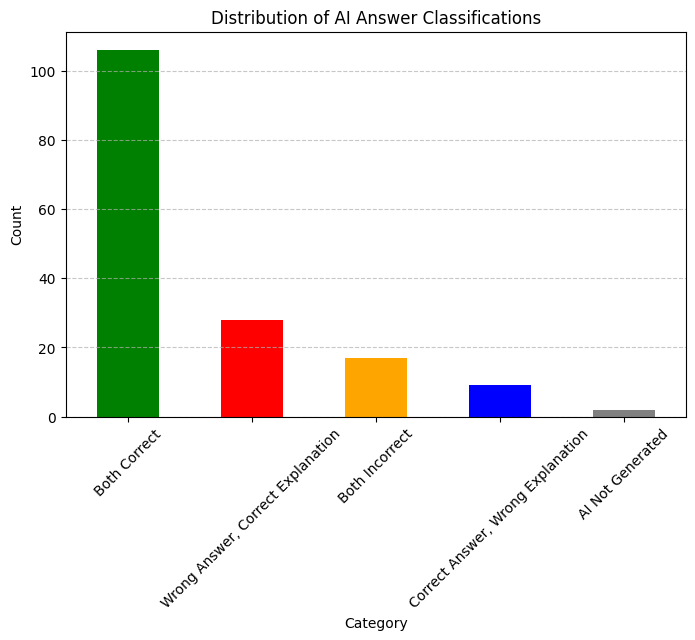

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each classification category
category_counts = df["Category"].value_counts()

# Compute percentages
category_percentages = (category_counts / len(df)) * 100

# Display statistical summary
print("Statistical Summary of AI Answer Classification:")
print(category_counts)
print("\nPercentage Distribution:")
print(category_percentages)

# Plot bar chart for better visualization
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["green", "red", "orange", "blue", "gray"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of AI Answer Classifications")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [8]:
df.to_csv("4o_mini_test_results.csv")